In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

In [14]:
mx = 32
mt = 128
n = 256
x_range = 1
t_range = 10

x = np.linspace(0, x_range, mx)
t = np.linspace(0, t_range, mt)

In [16]:
def curve_generator(x):
    model = Gaussian(dim =1,  var =50, len_scale= 0.6)
    srf= SRF(model)
    f = srf.structured([x])
    return f

U_in = np.concatenate([curve_generator(x)[np.newaxis,...] for _ in range(n) ]).T
U = np.repeat(U_in[:,np.newaxis,:], mt, axis=1)

(32, 128)
(32, 128)


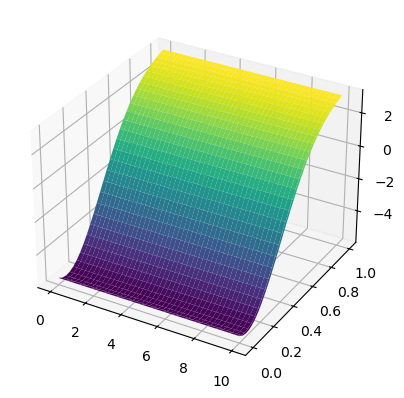

In [17]:
X, Y = np.meshgrid(t,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, U[:,:,12], cmap='viridis')

In [28]:
S = np.copy(U)
dx = abs(x[0]-x[1])
dt = abs(t[0]-t[1])
k = 0.006

const_val = k*(dt/dx**2)

for _t in range(0, mt - 1):
    S[1:-1, _t+1, :] = const_val*(S[ 2:, _t, :]-2*S[1:-1, _t, :] + S[0:-2, _t, :]) + S[1:-1, _t, :]

(32, 128)
(32, 128)


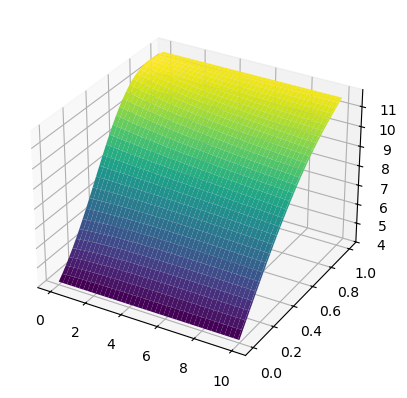

In [29]:
X, T = np.meshgrid(t[:],x)
print(X.shape)
print(T.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, T, S[:,:,1], cmap='viridis')

In [45]:
S_test.shape

torch.Size([156, 128, 32])

In [110]:
class DeepONetDS(torch.utils.data.Dataset):
    def __init__(self, U, X,T, S):
        torch.utils.data.Dataset.__init__(self)
        self.U = U
        self.X = X.reshape([-1,1])
        self.T = T.reshape([-1,1])
        self.S = S
        self.M_X = X.shape[0]
        self.M_T = self.T.shape[0]
        self.M_F = self.U.shape[0]

    def __len__(self):
        return self.M_X * self.M_T * self.M_F

    def __getitem__(self, idx):
        F_idx = idx % self.M_F
        T_idx = idx % self.M_T
        X_idx = idx % self.M_X
        # U[F,X] -> U[F,:]
        # S[X,T,F] -> S[X,]
        # print(T_idx, F_idx, X_idx)
        return self.U[F_idx,:], torch.cat([self.X[X_idx],self.T[T_idx]]), self.S[F_idx, T_idx, X_idx].reshape([-1,])

_U = torch.tensor(U_in.T, dtype=torch.float32)
U_train, U_test = _U[:200], _U[200:]

_S = torch.tensor(S.T, dtype=torch.float32)
S_train, S_test = _S[:200], _S[200:]

X = torch.tensor(x, dtype=torch.float32)
T = torch.tensor(t, dtype=torch.float32)

train_ds = DeepONetDS(U_train, X, T, S_train)
test_ds = DeepONetDS(U_test, X, T, S_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

In [111]:
torch.stack([torch.rand(2,1)[0],torch.rand(2,1)[0]],dim=1)

tensor([[0.0202, 0.7033]])

In [112]:
for u_,x_,s_ in train_dl:
    break

In [114]:
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1 = mx, in2= 2, output_neurons =20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.duble_neurons = 2*neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
        
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1,self.duble_neurons),
            nn.ReLU(),
            nn.Linear(self.duble_neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.output_neurons),
        )
        return branch
        
    def trunk_network(self):
        trunk=nn.Sequential(
            nn.Linear(self.in2,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.output_neurons),
        )
        return trunk
        
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1,x2)
        x = torch.unsqueeze(x,1)
        return x

In [124]:
model = DeepONet(neurons=40, in1 = mx, in2= 2, output_neurons =20)
loss = nn.MSELoss()
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)

In [125]:
import torch.nn as nn
import torch.optim as optim

train_looses = []

epochs = 600

for i in range(epochs):
    l_total = 0
    i = 0
    for u_, x_, s_ in train_dl:
        optimizer.zero_grad()
        print(f"Step: {i}",end='\r')
        y_pred = model(u_, x_)
        l = loss(y_pred, s_)
        l_total += l.item()
        l.backward()
        optimizer.step()
        i += 1
    
    l_total = l_total/ len(train_dl)
    train_looses.append(l_total)
    
    print("Epoch", i, " / ", epochs, "loss ", train_looses[-1])

Epoch 12800  /  600 loss  0.2728895947077035
Epoch 12800  /  600 loss  0.022104865594428702
Epoch 12800  /  600 loss  0.0156239040688979
Epoch 12800  /  600 loss  0.011874569675596832
Epoch 12800  /  600 loss  0.009460035321690157
Epoch 12800  /  600 loss  0.007866277066591465
Epoch 12800  /  600 loss  0.0070367893120919685
Epoch 12800  /  600 loss  0.006428890623856205


KeyboardInterrupt: 

In [121]:
y_pred = model(u_, x_)
l = loss(y_pred, s_)

In [123]:
l.item()

0.18483683466911316